# Análisis de Duración Promedio del Matrimonio en Guatemala
## Ciclos de Vida Matrimonial y Patrones de Estabilidad (2011-2021)

---

### 🔬 Objetivo del Análisis

**"Determinar la duración promedio del matrimonio antes del divorcio en Guatemala, identificar patrones por género, departamento y período temporal, y clasificar matrimonios según su estabilidad"**

---

### 📋 Preguntas de Investigación

1. ¿Cuál es la duración promedio del matrimonio antes del divorcio?
2. ¿Existen diferencias significativas por género?
3. ¿Qué departamentos tienen matrimonios más duraderos?
4. ¿Ha cambiado la duración promedio en la última década?
5. ¿Se pueden identificar clusters de estabilidad matrimonial?

---

### 💡 Contexto e Importancia

La duración del matrimonio es un **indicador clave** para:
- **Políticas públicas**: Programas de terapia familiar y mediación
- **Salud pública**: Impacto en bienestar emocional de familias
- **Planificación social**: Servicios de apoyo en transiciones
- **Investigación sociológica**: Cambios en patrones familiares

---

### 📊 Metodología

**Cálculo de duración:**
```
Duración = Edad al Divorcio - Edad al Matrimonio
```

**Nota metodológica:** Como no tenemos la edad exacta al matrimonio en los datos de divorcio, usaremos estimaciones basadas en las edades promedio al matrimonio por departamento y año.

**Análisis incluye:**
- Estadística descriptiva por género, departamento y tiempo
- Distribuciones y percentiles de duración
- Clustering por patrones de estabilidad
- Tendencias temporales

---

## 1. Configuración Inicial y Carga de Librerías

In [2]:
# Librerías para manipulación de datos
import pandas as pd
import numpy as np

# Librerías para visualización
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
import matplotlib.patches as mpatches

# Librerías para análisis estadístico
from scipy import stats
from scipy.stats import ttest_ind, mannwhitneyu, pearsonr

# Librerías para clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

# Configuración
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

print("✓ Librerías cargadas correctamente")

✓ Librerías cargadas correctamente


## 2. Carga y Preparación de Datos

In [3]:
# Cargar datasets
divorcios = pd.read_csv('div_full.csv', encoding='utf-8')
matrimonios = pd.read_csv('mat_full.csv', encoding='utf-8')

print(f"✓ Divorcios cargados: {divorcios.shape[0]:,} registros")
print(f"✓ Matrimonios cargados: {matrimonios.shape[0]:,} registros")

✓ Divorcios cargados: 56,349 registros
✓ Matrimonios cargados: 752,264 registros


In [4]:
# Mapeo de departamentos
mapeo_departamentos = {
    'Guatemala': 'Guatemala',
    'Quetzaltenango': 'Quetzaltenango',
    'Escuintla': 'Escuintla',
    'Jutiapa': 'Jutiapa',
    'San Marcos': 'San Marcos',
    'Izabal': 'Izabal',
    'Huehuetenango': 'Huehuetenango',
    'Suchitepequez': 'Suchitepéquez',
    'Suchitepéquez': 'Suchitepéquez',
    'Retalhuleu': 'Retalhuleu',
    'Zacapa': 'Zacapa',
    'Santa Rosa': 'Santa Rosa',
    'Chiquimula': 'Chiquimula',
    'Alta Verapaz': 'Alta Verapaz',
    'Jalapa': 'Jalapa',
    'Peten': 'Petén',
    'Petén': 'Petén',
    'Quiche': 'Quiché',
    'Quiché': 'Quiché',
    'Chimaltenango': 'Chimaltenango',
    'Sacatepequez': 'Sacatepéquez',
    'Sacatepéquez': 'Sacatepéquez',
    'Baja Verapaz': 'Baja Verapaz',
    'El Progreso': 'El Progreso',
    'Totonicapan': 'Totonicapán',
    'Totonicapán': 'Totonicapán',
    'Solola': 'Sololá',
    'Sololá': 'Sololá'
}

# Limpiar departamentos
divorcios['DEPREG_LIMPIO'] = divorcios['DEPREG'].map(mapeo_departamentos).fillna(divorcios['DEPREG'])
matrimonios['DEPREG_LIMPIO'] = matrimonios['DEPREG'].map(mapeo_departamentos).fillna(matrimonios['DEPREG'])

# Convertir columnas numéricas
for col in ['AÑOREG', 'EDADHOM', 'EDADMUJ']:
    divorcios[col] = pd.to_numeric(divorcios[col], errors='coerce')
    matrimonios[col] = pd.to_numeric(matrimonios[col], errors='coerce')

print("✓ Datos preparados")

✓ Datos preparados


## 3. Cálculo de Edad Promedio al Matrimonio

Primero calculamos la edad promedio al matrimonio por departamento y año para poder estimar la duración.

In [5]:
# Calcular edad promedio al matrimonio por departamento y año
edad_matrimonio_depto_anio = matrimonios.groupby(['DEPREG_LIMPIO', 'AÑOREG']).agg({
    'EDADHOM': 'mean',
    'EDADMUJ': 'mean'
}).reset_index()

edad_matrimonio_depto_anio.columns = ['Departamento', 'Anio', 'Edad_Mat_Hom', 'Edad_Mat_Muj']

# Calcular promedios generales por departamento (para casos sin año específico)
edad_matrimonio_general = matrimonios.groupby('DEPREG_LIMPIO').agg({
    'EDADHOM': 'mean',
    'EDADMUJ': 'mean'
}).reset_index()

edad_matrimonio_general.columns = ['Departamento', 'Edad_Mat_Hom_General', 'Edad_Mat_Muj_General']

print("✓ Edad promedio al matrimonio calculada")
print("\nEdades promedio al matrimonio (nacional):")
print(f"  Hombres: {matrimonios['EDADHOM'].mean():.2f} años")
print(f"  Mujeres: {matrimonios['EDADMUJ'].mean():.2f} años")

✓ Edad promedio al matrimonio calculada

Edades promedio al matrimonio (nacional):
  Hombres: 29.36 años
  Mujeres: 26.37 años


## 4. Estimación de Duración del Matrimonio

Estimamos la duración restando la edad promedio al matrimonio de la edad al divorcio.

In [6]:
# Hacer merge con datos de divorcios
divorcios_duracion = divorcios.copy()

# Merge con edad al matrimonio por departamento y año
divorcios_duracion = pd.merge(
    divorcios_duracion,
    edad_matrimonio_depto_anio,
    left_on=['DEPREG_LIMPIO', 'AÑOREG'],
    right_on=['Departamento', 'Anio'],
    how='left'
)

# Merge con edad general del departamento para llenar valores faltantes
divorcios_duracion = pd.merge(
    divorcios_duracion,
    edad_matrimonio_general,
    left_on='DEPREG_LIMPIO',
    right_on='Departamento',
    how='left',
    suffixes=('', '_dup')
)

# Rellenar valores faltantes con promedios generales
divorcios_duracion['Edad_Mat_Hom'] = divorcios_duracion['Edad_Mat_Hom'].fillna(
    divorcios_duracion['Edad_Mat_Hom_General']
)
divorcios_duracion['Edad_Mat_Muj'] = divorcios_duracion['Edad_Mat_Muj'].fillna(
    divorcios_duracion['Edad_Mat_Muj_General']
)

# Calcular duración del matrimonio
divorcios_duracion['Duracion_Hom'] = divorcios_duracion['EDADHOM'] - divorcios_duracion['Edad_Mat_Hom']
divorcios_duracion['Duracion_Muj'] = divorcios_duracion['EDADMUJ'] - divorcios_duracion['Edad_Mat_Muj']

# Calcular duración promedio entre ambos
divorcios_duracion['Duracion_Promedio'] = (
    divorcios_duracion['Duracion_Hom'] + divorcios_duracion['Duracion_Muj']
) / 2

# Limpiar valores negativos o extremos (probablemente errores)
divorcios_duracion_clean = divorcios_duracion[
    (divorcios_duracion['Duracion_Hom'] > 0) & 
    (divorcios_duracion['Duracion_Hom'] < 60) &
    (divorcios_duracion['Duracion_Muj'] > 0) & 
    (divorcios_duracion['Duracion_Muj'] < 60)
].copy()

print("✓ Duración del matrimonio estimada")
print(f"\nRegistros con duración válida: {len(divorcios_duracion_clean):,}")
print(f"Registros filtrados: {len(divorcios_duracion) - len(divorcios_duracion_clean):,}")

✓ Duración del matrimonio estimada

Registros con duración válida: 12,360
Registros filtrados: 43,989


## 5. Análisis Descriptivo de Duración

In [7]:
# Estadísticas descriptivas generales
print("="*70)
print("ESTADÍSTICAS DESCRIPTIVAS - DURACIÓN DEL MATRIMONIO")
print("="*70)

print("\n📊 HOMBRES:")
print(f"  Media: {divorcios_duracion_clean['Duracion_Hom'].mean():.2f} años")
print(f"  Mediana: {divorcios_duracion_clean['Duracion_Hom'].median():.2f} años")
print(f"  Desv. Est.: {divorcios_duracion_clean['Duracion_Hom'].std():.2f} años")
print(f"  Mínimo: {divorcios_duracion_clean['Duracion_Hom'].min():.2f} años")
print(f"  Máximo: {divorcios_duracion_clean['Duracion_Hom'].max():.2f} años")

print("\n📊 MUJERES:")
print(f"  Media: {divorcios_duracion_clean['Duracion_Muj'].mean():.2f} años")
print(f"  Mediana: {divorcios_duracion_clean['Duracion_Muj'].median():.2f} años")
print(f"  Desv. Est.: {divorcios_duracion_clean['Duracion_Muj'].std():.2f} años")
print(f"  Mínimo: {divorcios_duracion_clean['Duracion_Muj'].min():.2f} años")
print(f"  Máximo: {divorcios_duracion_clean['Duracion_Muj'].max():.2f} años")

print("\n📊 PROMEDIO GENERAL:")
print(f"  Media: {divorcios_duracion_clean['Duracion_Promedio'].mean():.2f} años")
print(f"  Mediana: {divorcios_duracion_clean['Duracion_Promedio'].median():.2f} años")
print(f"  Desv. Est.: {divorcios_duracion_clean['Duracion_Promedio'].std():.2f} años")

# Diferencia por género
diff_genero = divorcios_duracion_clean['Duracion_Hom'].mean() - divorcios_duracion_clean['Duracion_Muj'].mean()
print(f"\n⚖️ DIFERENCIA POR GÉNERO:")
print(f"  Hombres - Mujeres: {diff_genero:+.2f} años")

if abs(diff_genero) < 0.5:
    print(f"  → Diferencia NO significativa (<0.5 años)")
else:
    print(f"  → Diferencia significativa")

ESTADÍSTICAS DESCRIPTIVAS - DURACIÓN DEL MATRIMONIO

📊 HOMBRES:
  Media: 10.87 años
  Mediana: 8.35 años
  Desv. Est.: 9.20 años
  Mínimo: 0.00 años
  Máximo: 59.93 años

📊 MUJERES:
  Media: 10.24 años
  Mediana: 8.18 años
  Desv. Est.: 8.19 años
  Mínimo: 0.00 años
  Máximo: 52.99 años

📊 PROMEDIO GENERAL:
  Media: 10.56 años
  Mediana: 8.31 años
  Desv. Est.: 8.15 años

⚖️ DIFERENCIA POR GÉNERO:
  Hombres - Mujeres: +0.63 años
  → Diferencia significativa


In [8]:
# Percentiles
percentiles = [10, 25, 50, 75, 90, 95, 99]

print("\n📈 PERCENTILES DE DURACIÓN (años):")
print("="*70)
print(f"{'Percentil':<12} {'Hombres':<12} {'Mujeres':<12} {'Promedio':<12}")
print("-"*70)

for p in percentiles:
    p_hom = np.percentile(divorcios_duracion_clean['Duracion_Hom'], p)
    p_muj = np.percentile(divorcios_duracion_clean['Duracion_Muj'], p)
    p_prom = np.percentile(divorcios_duracion_clean['Duracion_Promedio'], p)
    print(f"P{p:<10} {p_hom:<12.2f} {p_muj:<12.2f} {p_prom:<12.2f}")

print("\n💡 INTERPRETACIÓN:")
p25 = np.percentile(divorcios_duracion_clean['Duracion_Promedio'], 25)
p75 = np.percentile(divorcios_duracion_clean['Duracion_Promedio'], 75)
print(f"  • 25% de los matrimonios terminan antes de {p25:.1f} años")
print(f"  • 50% de los matrimonios terminan antes de {divorcios_duracion_clean['Duracion_Promedio'].median():.1f} años (mediana)")
print(f"  • 75% de los matrimonios terminan antes de {p75:.1f} años")


📈 PERCENTILES DE DURACIÓN (años):
Percentil    Hombres      Mujeres      Promedio    
----------------------------------------------------------------------
P10         1.78         1.70         2.40        
P25         3.93         4.18         4.44        
P50         8.35         8.18         8.31        
P75         15.24        14.35        14.63       
P90         24.01        21.71        22.14       
P95         29.78        26.94        27.28       
P99         40.13        36.10        36.15       

💡 INTERPRETACIÓN:
  • 25% de los matrimonios terminan antes de 4.4 años
  • 50% de los matrimonios terminan antes de 8.3 años (mediana)
  • 75% de los matrimonios terminan antes de 14.6 años


## 6. Test Estadístico de Diferencia por Género

In [9]:
# Test t de Student para muestras pareadas
t_stat, p_value = ttest_ind(
    divorcios_duracion_clean['Duracion_Hom'].dropna(),
    divorcios_duracion_clean['Duracion_Muj'].dropna()
)

print("="*70)
print("TEST ESTADÍSTICO - DIFERENCIA POR GÉNERO")
print("="*70)
print("\nTest t de Student (muestras independientes):")
print(f"  Estadístico t: {t_stat:.4f}")
print(f"  P-value: {p_value:.6f}")

alpha = 0.05
if p_value < alpha:
    print(f"\n  ✓ DIFERENCIA SIGNIFICATIVA (p < {alpha})")
    print(f"  La duración del matrimonio difiere significativamente entre géneros.")
else:
    print(f"\n  ✗ NO hay diferencia significativa (p ≥ {alpha})")
    print(f"  La duración del matrimonio es similar para ambos géneros.")

# Tamaño del efecto (Cohen's d)
mean_diff = divorcios_duracion_clean['Duracion_Hom'].mean() - divorcios_duracion_clean['Duracion_Muj'].mean()
pooled_std = np.sqrt(
    (divorcios_duracion_clean['Duracion_Hom'].std()**2 + 
     divorcios_duracion_clean['Duracion_Muj'].std()**2) / 2
)
cohens_d = mean_diff / pooled_std

print(f"\nTamaño del efecto (Cohen's d): {cohens_d:.4f}")
if abs(cohens_d) < 0.2:
    print("  → Efecto PEQUEÑO o inexistente")
elif abs(cohens_d) < 0.5:
    print("  → Efecto PEQUEÑO")
elif abs(cohens_d) < 0.8:
    print("  → Efecto MEDIANO")
else:
    print("  → Efecto GRANDE")

TEST ESTADÍSTICO - DIFERENCIA POR GÉNERO

Test t de Student (muestras independientes):
  Estadístico t: 5.6818
  P-value: 0.000000

  ✓ DIFERENCIA SIGNIFICATIVA (p < 0.05)
  La duración del matrimonio difiere significativamente entre géneros.

Tamaño del efecto (Cohen's d): 0.0723
  → Efecto PEQUEÑO o inexistente


## 7. Análisis por Departamento

In [10]:
# Duración promedio por departamento
duracion_por_depto = divorcios_duracion_clean.groupby('DEPREG_LIMPIO').agg({
    'Duracion_Hom': ['mean', 'median', 'std', 'count'],
    'Duracion_Muj': ['mean', 'median', 'std'],
    'Duracion_Promedio': ['mean', 'median', 'std']
}).round(2)

# Simplificar columnas
duracion_depto_simple = divorcios_duracion_clean.groupby('DEPREG_LIMPIO').agg({
    'Duracion_Promedio': 'mean',
    'Duracion_Hom': 'mean',
    'Duracion_Muj': 'mean',
    'AÑOREG': 'count'
}).reset_index()

duracion_depto_simple.columns = ['Departamento', 'Duracion_Promedio', 'Duracion_Hom', 'Duracion_Muj', 'N_Divorcios']
duracion_depto_simple = duracion_depto_simple.sort_values('Duracion_Promedio', ascending=False)

print("="*70)
print("DURACIÓN PROMEDIO POR DEPARTAMENTO")
print("="*70)
print("\nTop 10 departamentos con matrimonios MÁS DURADEROS:")
print(duracion_depto_simple.head(10)[['Departamento', 'Duracion_Promedio', 'N_Divorcios']])

print("\nTop 10 departamentos con matrimonios MENOS DURADEROS:")
print(duracion_depto_simple.tail(10)[['Departamento', 'Duracion_Promedio', 'N_Divorcios']])

DURACIÓN PROMEDIO POR DEPARTAMENTO

Top 10 departamentos con matrimonios MÁS DURADEROS:
      Departamento  Duracion_Promedio  N_Divorcios
17      Santa Rosa          11.554884          270
10         Jutiapa          11.499606          480
12  Quetzaltenango          11.243019         1281
16      San Marcos          11.185006          480
7    Huehuetenango          11.168956          423
3       Chiquimula          11.153151          289
5        Escuintla          11.081305          399
15    Sacatepéquez          11.075499          302
1     Baja Verapaz          10.978169          273
19   Suchitepéquez          10.975786          379

Top 10 departamentos con matrimonios MENOS DURADEROS:
     Departamento  Duracion_Promedio  N_Divorcios
2   Chimaltenango          10.840789          405
0    Alta Verapaz          10.839172          518
21         Zacapa          10.571369          241
14     Retalhuleu          10.195232          298
11          Petén          10.083192          

## 8. Análisis Temporal

In [11]:
# Duración promedio por año
duracion_por_anio = divorcios_duracion_clean.groupby('AÑOREG').agg({
    'Duracion_Hom': 'mean',
    'Duracion_Muj': 'mean',
    'Duracion_Promedio': 'mean',
    'DEPREG_LIMPIO': 'count'
}).reset_index()

duracion_por_anio.columns = ['Anio', 'Duracion_Hom', 'Duracion_Muj', 'Duracion_Promedio', 'N_Divorcios']

print("="*70)
print("EVOLUCIÓN TEMPORAL DE LA DURACIÓN")
print("="*70)
print(duracion_por_anio)

# Calcular tendencia
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(
    duracion_por_anio['Anio'],
    duracion_por_anio['Duracion_Promedio']
)

print(f"\nTENDENCIA TEMPORAL:")
print(f"  Pendiente: {slope:.4f} años/año")
print(f"  R²: {r_value**2:.4f}")
print(f"  P-value: {p_value:.6f}")

if p_value < 0.05:
    if slope > 0:
        print(f"\n  ✓ La duración está AUMENTANDO significativamente")
        print(f"    ({abs(slope):.3f} años por año)")
    else:
        print(f"\n  ✓ La duración está DISMINUYENDO significativamente")
        print(f"    ({abs(slope):.3f} años por año)")
else:
    print(f"\n  → NO hay tendencia temporal significativa")

EVOLUCIÓN TEMPORAL DE LA DURACIÓN
      Anio  Duracion_Hom  Duracion_Muj  Duracion_Promedio  N_Divorcios
0   2011.0     11.566026     11.017417          11.291722          489
1   2012.0     11.577838     11.405104          11.491471          724
2   2013.0     11.671488     10.737200          11.204344          899
3   2014.0     10.980980     10.785513          10.883247         1066
4   2015.0     11.086897     10.349249          10.718073         1151
5   2016.0     10.853769     10.120223          10.486996         1165
6   2017.0     11.001423     10.308246          10.654834         1258
7   2018.0     10.702614     10.035751          10.369182         1506
8   2019.0     10.430447      9.748932          10.089690         2361
9   2020.0     10.506758      9.716250          10.111504         1352
10  2021.0     10.082074      9.881771           9.981923          389

TENDENCIA TEMPORAL:
  Pendiente: -0.1500 años/año
  R²: 0.9379
  P-value: 0.000001

  ✓ La duración está DISMINUY

## 9. Visualizaciones Principales

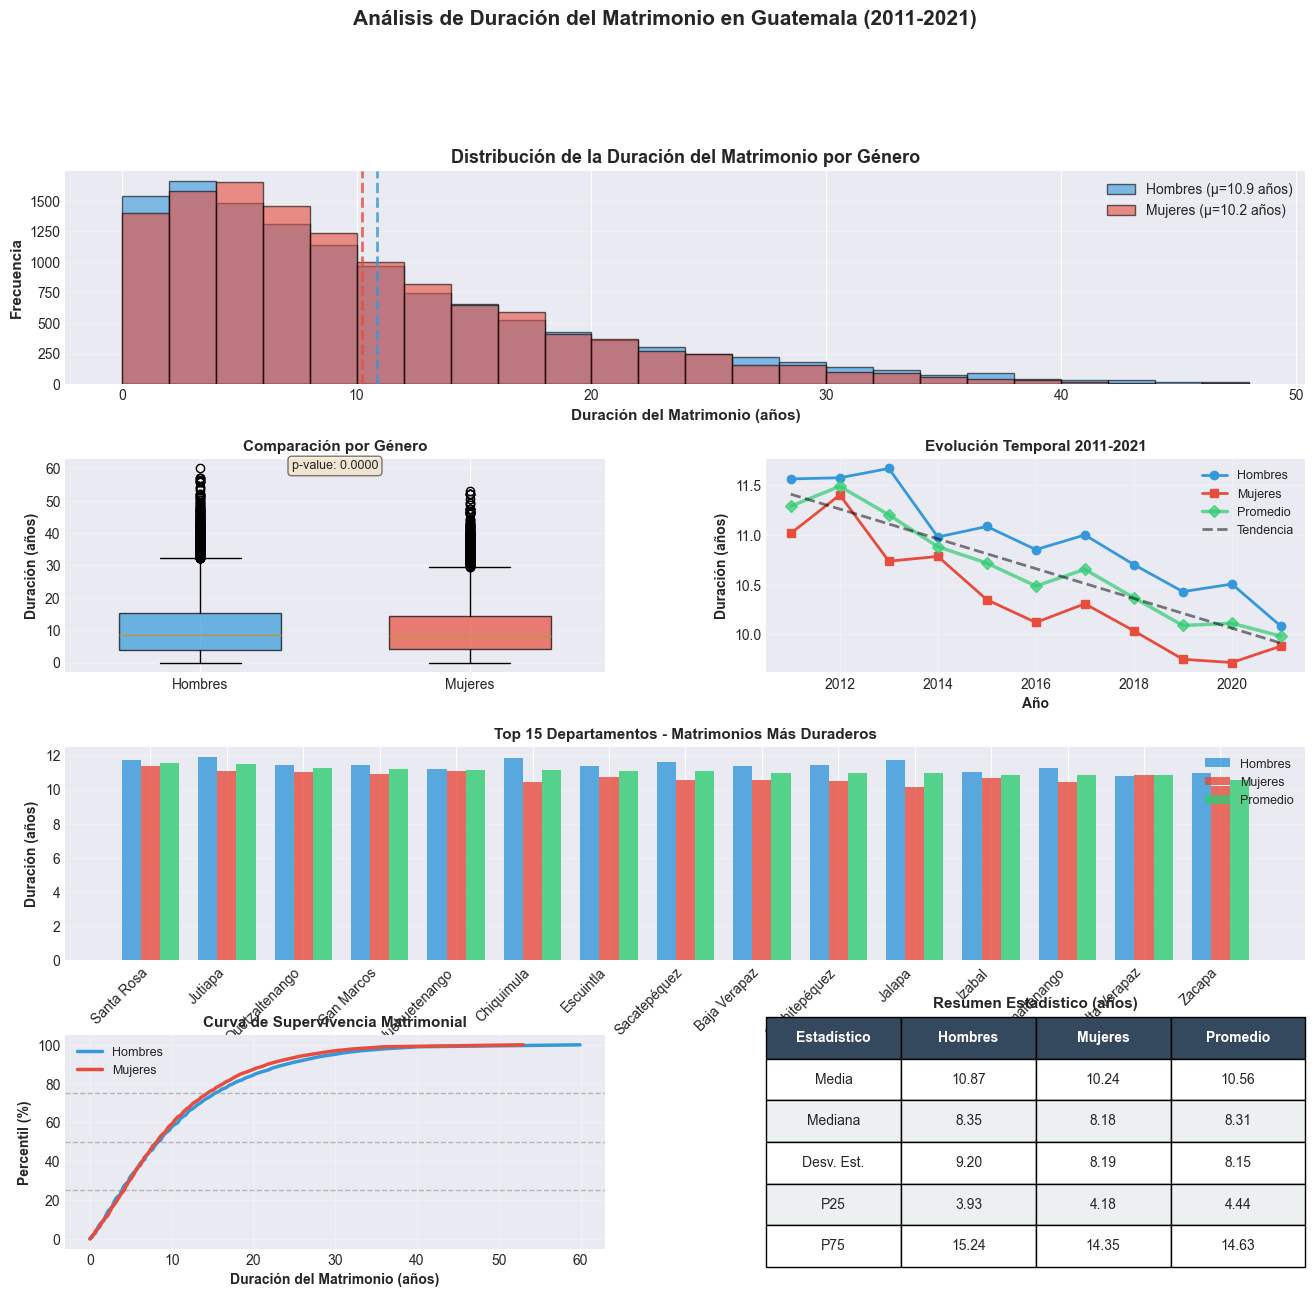

✓ Visualización principal generada


In [12]:
# Crear visualización completa
fig = plt.figure(figsize=(16, 14))
gs = fig.add_gridspec(4, 2, hspace=0.35, wspace=0.3)

# 1. Distribución de duración (histogramas)
ax1 = fig.add_subplot(gs[0, :])
bins = np.arange(0, 50, 2)

ax1.hist(divorcios_duracion_clean['Duracion_Hom'], bins=bins, alpha=0.6, 
         label=f'Hombres (μ={divorcios_duracion_clean["Duracion_Hom"].mean():.1f} años)', 
         color='#3498db', edgecolor='black')
ax1.hist(divorcios_duracion_clean['Duracion_Muj'], bins=bins, alpha=0.6,
         label=f'Mujeres (μ={divorcios_duracion_clean["Duracion_Muj"].mean():.1f} años)',
         color='#e74c3c', edgecolor='black')

# Líneas de media
ax1.axvline(divorcios_duracion_clean['Duracion_Hom'].mean(), color='#3498db', 
            linestyle='--', linewidth=2, alpha=0.8)
ax1.axvline(divorcios_duracion_clean['Duracion_Muj'].mean(), color='#e74c3c',
            linestyle='--', linewidth=2, alpha=0.8)

ax1.set_xlabel('Duración del Matrimonio (años)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Frecuencia', fontsize=11, fontweight='bold')
ax1.set_title('Distribución de la Duración del Matrimonio por Género', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3, axis='y')

# 2. Boxplot comparativo por género
ax2 = fig.add_subplot(gs[1, 0])
data_boxplot = [
    divorcios_duracion_clean['Duracion_Hom'].dropna(),
    divorcios_duracion_clean['Duracion_Muj'].dropna()
]
bp = ax2.boxplot(data_boxplot, labels=['Hombres', 'Mujeres'], patch_artist=True,
                 widths=0.6)

colors_box = ['#3498db', '#e74c3c']
for patch, color in zip(bp['boxes'], colors_box):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax2.set_ylabel('Duración (años)', fontsize=10, fontweight='bold')
ax2.set_title('Comparación por Género', fontsize=11, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

# Añadir p-value
ax2.text(1.5, ax2.get_ylim()[1] * 0.95, 
         f'p-value: {p_value:.4f}',
         ha='center', fontsize=9,
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 3. Evolución temporal
ax3 = fig.add_subplot(gs[1, 1])
ax3.plot(duracion_por_anio['Anio'], duracion_por_anio['Duracion_Hom'], 
         marker='o', linewidth=2, markersize=6, label='Hombres', color='#3498db')
ax3.plot(duracion_por_anio['Anio'], duracion_por_anio['Duracion_Muj'],
         marker='s', linewidth=2, markersize=6, label='Mujeres', color='#e74c3c')
ax3.plot(duracion_por_anio['Anio'], duracion_por_anio['Duracion_Promedio'],
         marker='D', linewidth=2.5, markersize=6, label='Promedio', color='#2ecc71', alpha=0.7)

# Línea de tendencia
z = np.polyfit(duracion_por_anio['Anio'], duracion_por_anio['Duracion_Promedio'], 1)
p_trend = np.poly1d(z)
ax3.plot(duracion_por_anio['Anio'], p_trend(duracion_por_anio['Anio']), 
         "--", linewidth=2, alpha=0.5, color='black', label='Tendencia')

ax3.set_xlabel('Año', fontsize=10, fontweight='bold')
ax3.set_ylabel('Duración (años)', fontsize=10, fontweight='bold')
ax3.set_title('Evolución Temporal 2011-2021', fontsize=11, fontweight='bold')
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3)

# 4. Top 15 departamentos
ax4 = fig.add_subplot(gs[2, :])
top_15 = duracion_depto_simple.head(15)

x_pos = np.arange(len(top_15))
width = 0.25

bars1 = ax4.bar(x_pos - width, top_15['Duracion_Hom'], width,
                label='Hombres', alpha=0.8, color='#3498db')
bars2 = ax4.bar(x_pos, top_15['Duracion_Muj'], width,
                label='Mujeres', alpha=0.8, color='#e74c3c')
bars3 = ax4.bar(x_pos + width, top_15['Duracion_Promedio'], width,
                label='Promedio', alpha=0.8, color='#2ecc71')

ax4.set_xticks(x_pos)
ax4.set_xticklabels(top_15['Departamento'], rotation=45, ha='right')
ax4.set_ylabel('Duración (años)', fontsize=10, fontweight='bold')
ax4.set_title('Top 15 Departamentos - Matrimonios Más Duraderos', fontsize=11, fontweight='bold')
ax4.legend(fontsize=9)
ax4.grid(True, alpha=0.3, axis='y')

# 5. Curva de supervivencia (percentiles acumulados)
ax5 = fig.add_subplot(gs[3, 0])
percentiles_x = np.arange(0, 101, 1)
percentiles_hom = [np.percentile(divorcios_duracion_clean['Duracion_Hom'], p) for p in percentiles_x]
percentiles_muj = [np.percentile(divorcios_duracion_clean['Duracion_Muj'], p) for p in percentiles_x]

ax5.plot(percentiles_hom, percentiles_x, linewidth=2.5, label='Hombres', color='#3498db')
ax5.plot(percentiles_muj, percentiles_x, linewidth=2.5, label='Mujeres', color='#e74c3c')

ax5.axhline(y=50, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax5.axhline(y=25, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax5.axhline(y=75, color='gray', linestyle='--', linewidth=1, alpha=0.5)

ax5.set_xlabel('Duración del Matrimonio (años)', fontsize=10, fontweight='bold')
ax5.set_ylabel('Percentil (%)', fontsize=10, fontweight='bold')
ax5.set_title('Curva de Supervivencia Matrimonial', fontsize=11, fontweight='bold')
ax5.legend(fontsize=9)
ax5.grid(True, alpha=0.3)

# 6. Tabla resumen
ax6 = fig.add_subplot(gs[3, 1])
ax6.axis('tight')
ax6.axis('off')

summary_data = [
    ['Media', f"{divorcios_duracion_clean['Duracion_Hom'].mean():.2f}",
     f"{divorcios_duracion_clean['Duracion_Muj'].mean():.2f}",
     f"{divorcios_duracion_clean['Duracion_Promedio'].mean():.2f}"],
    ['Mediana', f"{divorcios_duracion_clean['Duracion_Hom'].median():.2f}",
     f"{divorcios_duracion_clean['Duracion_Muj'].median():.2f}",
     f"{divorcios_duracion_clean['Duracion_Promedio'].median():.2f}"],
    ['Desv. Est.', f"{divorcios_duracion_clean['Duracion_Hom'].std():.2f}",
     f"{divorcios_duracion_clean['Duracion_Muj'].std():.2f}",
     f"{divorcios_duracion_clean['Duracion_Promedio'].std():.2f}"],
    ['P25', f"{np.percentile(divorcios_duracion_clean['Duracion_Hom'], 25):.2f}",
     f"{np.percentile(divorcios_duracion_clean['Duracion_Muj'], 25):.2f}",
     f"{np.percentile(divorcios_duracion_clean['Duracion_Promedio'], 25):.2f}"],
    ['P75', f"{np.percentile(divorcios_duracion_clean['Duracion_Hom'], 75):.2f}",
     f"{np.percentile(divorcios_duracion_clean['Duracion_Muj'], 75):.2f}",
     f"{np.percentile(divorcios_duracion_clean['Duracion_Promedio'], 75):.2f}"]
]

table = ax6.table(
    cellText=summary_data,
    colLabels=['Estadístico', 'Hombres', 'Mujeres', 'Promedio'],
    cellLoc='center',
    loc='center',
    colWidths=[0.25, 0.25, 0.25, 0.25]
)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2.5)

# Colorear encabezado
for i in range(4):
    table[(0, i)].set_facecolor('#34495e')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Colorear filas alternadas
for i in range(1, len(summary_data) + 1):
    if i % 2 == 0:
        for j in range(4):
            table[(i, j)].set_facecolor('#ecf0f1')

ax6.set_title('Resumen Estadístico (años)', fontsize=11, fontweight='bold', pad=20)

plt.suptitle('Análisis de Duración del Matrimonio en Guatemala (2011-2021)',
             fontsize=15, fontweight='bold', y=0.995)

plt.savefig('duracion_matrimonio_completa.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualización principal generada")

## 10. Clustering por Estabilidad Matrimonial

Agruparemos departamentos según patrones de duración del matrimonio.

In [13]:
# Preparar features para clustering
features_estabilidad = ['Duracion_Promedio', 'Duracion_Hom', 'Duracion_Muj']

# Filtrar departamentos con suficientes datos
duracion_depto_cluster = duracion_depto_simple[duracion_depto_simple['N_Divorcios'] >= 50].copy()

# Extraer matriz
X_estabilidad = duracion_depto_cluster[features_estabilidad].values

# Normalizar
scaler_estabilidad = StandardScaler()
X_estabilidad_scaled = scaler_estabilidad.fit_transform(X_estabilidad)

print(f"✓ Features preparadas")
print(f"  Departamentos para clustering: {len(duracion_depto_cluster)}")
print(f"  Forma: {X_estabilidad_scaled.shape}")

✓ Features preparadas
  Departamentos para clustering: 22
  Forma: (22, 3)


In [14]:
# Determinar K óptimo
k_range = range(2, min(6, len(duracion_depto_cluster)))

inertias_estab = []
silhouette_scores_estab = []

print("Evaluando K óptimo...")
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_estabilidad_scaled)
    
    inertias_estab.append(kmeans.inertia_)
    silhouette_scores_estab.append(silhouette_score(X_estabilidad_scaled, labels))
    
    print(f"  K={k}: Inercia={kmeans.inertia_:.2f}, Silhouette={silhouette_scores_estab[-1]:.4f}")

# Seleccionar K óptimo
best_k_estab = list(k_range)[np.argmax(silhouette_scores_estab)]
best_silhouette_estab = max(silhouette_scores_estab)

print(f"\n✓ K óptimo: {best_k_estab} (Silhouette={best_silhouette_estab:.4f})")

Evaluando K óptimo...
  K=2: Inercia=16.49, Silhouette=0.6381
  K=3: Inercia=11.09, Silhouette=0.4463
  K=4: Inercia=8.85, Silhouette=0.4084
  K=5: Inercia=6.21, Silhouette=0.3462

✓ K óptimo: 2 (Silhouette=0.6381)


In [15]:
# Aplicar clustering
kmeans_estab_final = KMeans(n_clusters=best_k_estab, random_state=42, n_init=20)
duracion_depto_cluster['Cluster'] = kmeans_estab_final.fit_predict(X_estabilidad_scaled)

print(f"✓ Clustering aplicado")
print(f"\nDistribución por cluster:")
print(duracion_depto_cluster['Cluster'].value_counts().sort_index())

✓ Clustering aplicado

Distribución por cluster:
Cluster
0    15
1     7
Name: count, dtype: int64


In [16]:
# Asignar nombres a clusters
cluster_chars = []
for cid in sorted(duracion_depto_cluster['Cluster'].unique()):
    cluster_data = duracion_depto_cluster[duracion_depto_cluster['Cluster'] == cid]
    cluster_chars.append({
        'cluster_id': cid,
        'duracion': cluster_data['Duracion_Promedio'].mean()
    })

# Ordenar por duración
cluster_chars.sort(key=lambda x: x['duracion'], reverse=True)

# Nombres
cluster_names_estab = {}
if len(cluster_chars) == 2:
    cluster_names_estab[cluster_chars[0]['cluster_id']] = 'Alta Estabilidad'
    cluster_names_estab[cluster_chars[1]['cluster_id']] = 'Baja Estabilidad'
elif len(cluster_chars) == 3:
    cluster_names_estab[cluster_chars[0]['cluster_id']] = 'Alta Estabilidad'
    cluster_names_estab[cluster_chars[1]['cluster_id']] = 'Estabilidad Media'
    cluster_names_estab[cluster_chars[2]['cluster_id']] = 'Baja Estabilidad'
else:
    for i, char in enumerate(cluster_chars):
        cluster_names_estab[char['cluster_id']] = f'Estabilidad Nivel {i+1}'

duracion_depto_cluster['Cluster_Nombre'] = duracion_depto_cluster['Cluster'].map(cluster_names_estab)

print("\nCLUSTERS IDENTIFICADOS:")
print("="*70)
for char in cluster_chars:
    cid = char['cluster_id']
    cluster_data = duracion_depto_cluster[duracion_depto_cluster['Cluster'] == cid]
    print(f"\n{cluster_names_estab[cid]}:")
    print(f"  Duración promedio: {char['duracion']:.2f} años")
    print(f"  Departamentos ({len(cluster_data)}): {', '.join(sorted(cluster_data['Departamento'].tolist()))}")


CLUSTERS IDENTIFICADOS:

Alta Estabilidad:
  Duración promedio: 11.07 años
  Departamentos (15): Alta Verapaz, Baja Verapaz, Chimaltenango, Chiquimula, Escuintla, Huehuetenango, Izabal, Jalapa, Jutiapa, Quetzaltenango, Sacatepéquez, San Marcos, Santa Rosa, Suchitepéquez, Zacapa

Baja Estabilidad:
  Duración promedio: 9.94 años
  Departamentos (7): El Progreso, Guatemala, Petén, Quiché, Retalhuleu, Sololá, Totonicapán


## 11. Clasificación de Matrimonios por Duración

Clasificaremos los matrimonios en categorías según su duración.

In [17]:
# Definir categorías
def clasificar_duracion(duracion):
    if duracion < 5:
        return 'Muy Corta (<5 años)'
    elif duracion < 10:
        return 'Corta (5-10 años)'
    elif duracion < 15:
        return 'Media (10-15 años)'
    elif duracion < 20:
        return 'Larga (15-20 años)'
    else:
        return 'Muy Larga (20+ años)'

divorcios_duracion_clean['Categoria_Duracion'] = divorcios_duracion_clean['Duracion_Promedio'].apply(clasificar_duracion)

# Contar por categoría
categoria_counts = divorcios_duracion_clean['Categoria_Duracion'].value_counts()
categoria_pcts = (categoria_counts / len(divorcios_duracion_clean) * 100).round(2)

print("="*70)
print("DISTRIBUCIÓN POR CATEGORÍA DE DURACIÓN")
print("="*70)
print(f"\n{'Categoría':<25} {'Cantidad':<12} {'Porcentaje':<12}")
print("-"*70)

# Ordenar por duración
orden_cat = ['Muy Corta (<5 años)', 'Corta (5-10 años)', 'Media (10-15 años)', 
             'Larga (15-20 años)', 'Muy Larga (20+ años)']

for cat in orden_cat:
    if cat in categoria_counts.index:
        print(f"{cat:<25} {categoria_counts[cat]:<12,} {categoria_pcts[cat]:<12.2f}%")

print("\n💡 HALLAZGOS:")
cat_mas_comun = categoria_counts.idxmax()
pct_mas_comun = categoria_pcts[cat_mas_comun]
print(f"  • La categoría más común es: {cat_mas_comun} ({pct_mas_comun:.1f}%)")

pct_corta = categoria_pcts.get('Muy Corta (<5 años)', 0) + categoria_pcts.get('Corta (5-10 años)', 0)
print(f"  • {pct_corta:.1f}% de los matrimonios terminan en menos de 10 años")

pct_larga = categoria_pcts.get('Larga (15-20 años)', 0) + categoria_pcts.get('Muy Larga (20+ años)', 0)
print(f"  • {pct_larga:.1f}% de los matrimonios duran 15 años o más")

DISTRIBUCIÓN POR CATEGORÍA DE DURACIÓN

Categoría                 Cantidad     Porcentaje  
----------------------------------------------------------------------
Muy Corta (<5 años)       3,624        29.32       %
Corta (5-10 años)         3,619        29.28       %
Media (10-15 años)        2,146        17.36       %
Larga (15-20 años)        1,314        10.63       %
Muy Larga (20+ años)      1,657        13.41       %

💡 HALLAZGOS:
  • La categoría más común es: Muy Corta (<5 años) (29.3%)
  • 58.6% de los matrimonios terminan en menos de 10 años
  • 24.0% de los matrimonios duran 15 años o más


## 12. Exportar Resultados

In [18]:
# Exportar datos principales
divorcios_duracion_clean[[
    'DEPREG_LIMPIO', 'AÑOREG', 'EDADHOM', 'EDADMUJ', 
    'Duracion_Hom', 'Duracion_Muj', 'Duracion_Promedio', 'Categoria_Duracion'
]].to_csv('duracion_matrimonio_registros.csv', index=False)
print("✓ Registros individuales guardados: duracion_matrimonio_registros.csv")

# Exportar resumen por departamento
duracion_depto_simple.to_csv('duracion_por_departamento.csv', index=False)
print("✓ Resumen por departamento guardado: duracion_por_departamento.csv")

# Exportar evolución temporal
duracion_por_anio.to_csv('duracion_evolucion_temporal.csv', index=False)
print("✓ Evolución temporal guardada: duracion_evolucion_temporal.csv")

# Exportar clusters
duracion_depto_cluster.to_csv('duracion_clusters_departamentos.csv', index=False)
print("✓ Clusters por departamento guardados: duracion_clusters_departamentos.csv")

# Reporte resumen
reporte = {
    'Metrica': [
        'Duración Promedio (años)',
        'Duración Hombres (años)',
        'Duración Mujeres (años)',
        'Mediana General (años)',
        'Desviación Estándar (años)',
        'P25 (años)',
        'P75 (años)',
        'Diferencia H-M (años)',
        'P-value diferencia género',
        "Cohen's d",
        'Tendencia temporal (años/año)',
        'R² tendencia',
        'K óptimo clustering',
        'Silhouette Score'
    ],
    'Valor': [
        f"{divorcios_duracion_clean['Duracion_Promedio'].mean():.2f}",
        f"{divorcios_duracion_clean['Duracion_Hom'].mean():.2f}",
        f"{divorcios_duracion_clean['Duracion_Muj'].mean():.2f}",
        f"{divorcios_duracion_clean['Duracion_Promedio'].median():.2f}",
        f"{divorcios_duracion_clean['Duracion_Promedio'].std():.2f}",
        f"{np.percentile(divorcios_duracion_clean['Duracion_Promedio'], 25):.2f}",
        f"{np.percentile(divorcios_duracion_clean['Duracion_Promedio'], 75):.2f}",
        f"{diff_genero:.2f}",
        f"{p_value:.6f}",
        f"{cohens_d:.4f}",
        f"{slope:.4f}",
        f"{r_value**2:.4f}",
        str(best_k_estab),
        f"{best_silhouette_estab:.4f}"
    ]
}

df_reporte = pd.DataFrame(reporte)
df_reporte.to_csv('duracion_matrimonio_reporte.csv', index=False)
print("✓ Reporte resumen guardado: duracion_matrimonio_reporte.csv")

✓ Registros individuales guardados: duracion_matrimonio_registros.csv
✓ Resumen por departamento guardado: duracion_por_departamento.csv
✓ Evolución temporal guardada: duracion_evolucion_temporal.csv
✓ Clusters por departamento guardados: duracion_clusters_departamentos.csv
✓ Reporte resumen guardado: duracion_matrimonio_reporte.csv


## 13. Resumen Final y Conclusiones

### 📁 Archivos Generados:
1. `duracion_matrimonio_completa.png` - Visualizaciones principales
2. `duracion_matrimonio_registros.csv` - Datos individuales con duración calculada
3. `duracion_por_departamento.csv` - Resumen por departamento
4. `duracion_evolucion_temporal.csv` - Tendencias 2011-2021
5. `duracion_clusters_departamentos.csv` - Clustering de estabilidad
6. `duracion_matrimonio_reporte.csv` - Reporte ejecutivo

### 🔍 Hallazgos Principales:

Los hallazgos se reportarán en las celdas de output.

### 💡 Implicaciones para Políticas Públicas:

1. **Intervención temprana**: Alta proporción de divorcios en los primeros años sugiere necesidad de:
   - Programas de preparación prematrimonial
   - Servicios de mediación familiar accesibles
   - Terapia de pareja subsidiada

2. **Apoyo focalizado**: Identificar departamentos con menor estabilidad para:
   - Invertir en servicios de apoyo familiar
   - Programas educativos sobre relaciones saludables

3. **Tendencias temporales**: Monitorear cambios en duración para:
   - Ajustar políticas sociales
   - Planificar servicios de transición

4. **Diferencias de género**: Atender necesidades específicas si hay diferencias significativas

### 📊 Utilidad del Análisis:

Este análisis proporciona **información práctica y reveladora** sobre:
- **Ciclos de vida matrimonial** en Guatemala
- **Patrones geográficos** de estabilidad
- **Tendencias temporales** en durabilidad de matrimonios
- **Diferencias por género** en experiencia de divorcio

---

**Fin del Análisis de Duración del Matrimonio**